In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [21]:
# Load data
url = 'https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(2)/file_gabungan2.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,Lenovo Legion Y540 - i7 9750H 16GB 512ssd 1TB ...,16999000,2013-01-01,13
1,ASUS ROG G531GU-I566G2T i5 9300H|8GB|512GB SSD...,16899000,2013-01-02,11
2,ASUS ROG GU502GU-I7664B Zephyrus M i7 9750H|16...,28299000,2013-01-03,14
3,ASUS ROG Strix G531GV-I7R6S1T [Scar 3],30999000,2013-01-04,13
4,ASUS ROG G531GT-I765G1T STRIX III i7-9750H 8GB...,16999000,2013-01-05,10
5,ASUS ROG HERO G531GU-I766H2T i7-9750H-16GB-256...,24590000,2013-01-06,12
6,ASUS ROG STRIX III G531GT-I765G4B i7-9750H|8GB...,17499000,2013-01-07,10
7,Asus ROG Zephyrus M GX502GW i7 9750 16GB 1TB S...,29199000,2013-01-08,9
8,ASUS ROG STRIX G G731GT,18499000,2013-01-09,12
9,ASUS ROG STRIX G512LU-I766B6T i7-10750H 8GB 51...,20553000,2013-01-10,9


In [22]:
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103000 entries, 0 to 102999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   name    103000 non-null  object        
 1   price   103000 non-null  int64         
 2   date    103000 non-null  datetime64[ns]
 3   sales   103000 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.1+ MB


In [23]:
# Categorize data based on price
def categorize_price(price):
    if price < 8000000:
        return 'low'
    elif 8000000 <= price < 16000000:
        return 'mid'
    else:
        return 'high'

store_sales['category'] = store_sales['price'].apply(categorize_price)

In [24]:
# Drop unnecessary columns
store_sales = store_sales.drop(['name', 'price'], axis=1)
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103000 entries, 0 to 102999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      103000 non-null  datetime64[ns]
 1   sales     103000 non-null  int64         
 2   category  103000 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.4+ MB


In [25]:
# Function to process and predict for each category
def process_category(data, category_name):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Prepare supervised data
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, 13):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Split into train and test data
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]

    # Convert to DataFrame to retain column names
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_df = pd.DataFrame(train_data, columns=supervised_data.columns)
    test_data_df = pd.DataFrame(test_data, columns=supervised_data.columns)

    # Scale the data
    scaler.fit(train_data_df)
    train_data_scaled = scaler.transform(train_data_df)
    test_data_scaled = scaler.transform(test_data_df)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(50, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_{category_name}.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, model_checkpoint], verbose=1)

    # Save the model
    model.save(f'best_model_{category_name}.keras')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = monthly_sales['sales'][-13:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 12 months
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(12):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + monthly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return monthly_sales, predict_df, future_df

# Process and predict for each category
low_sales, low_predict_df, low_future_df = process_category(store_sales, 'low')
mid_sales, mid_predict_df, mid_future_df = process_category(store_sales, 'mid')
high_sales, high_predict_df, high_future_df = process_category(store_sales, 'high')


Epoch 1/100
2/2 [==============================] - 3s 620ms/step - loss: 0.2443 - val_loss: 0.6130
Epoch 2/100
2/2 [==============================] - 0s 62ms/step - loss: 0.2385 - val_loss: 0.6106
Epoch 3/100
2/2 [==============================] - 0s 62ms/step - loss: 0.2338 - val_loss: 0.6097
Epoch 4/100
2/2 [==============================] - 0s 63ms/step - loss: 0.2301 - val_loss: 0.6093
Epoch 5/100
2/2 [==============================] - 0s 38ms/step - loss: 0.2273 - val_loss: 0.6094
Epoch 6/100
2/2 [==============================] - 0s 65ms/step - loss: 0.2261 - val_loss: 0.6107
Epoch 7/100
2/2 [==============================] - 0s 37ms/step - loss: 0.2263 - val_loss: 0.6097
Epoch 8/100
2/2 [==============================] - 0s 76ms/step - loss: 0.2251 - val_loss: 0.6058
Epoch 9/100
2/2 [==============================] - 0s 92ms/step - loss: 0.2236 - val_loss: 0.6009
Epoch 10/100
2/2 [==============================] - 0s 94ms/step - loss: 0.2215 - val_loss: 0.5942
Epoch 11/100
2/2 [

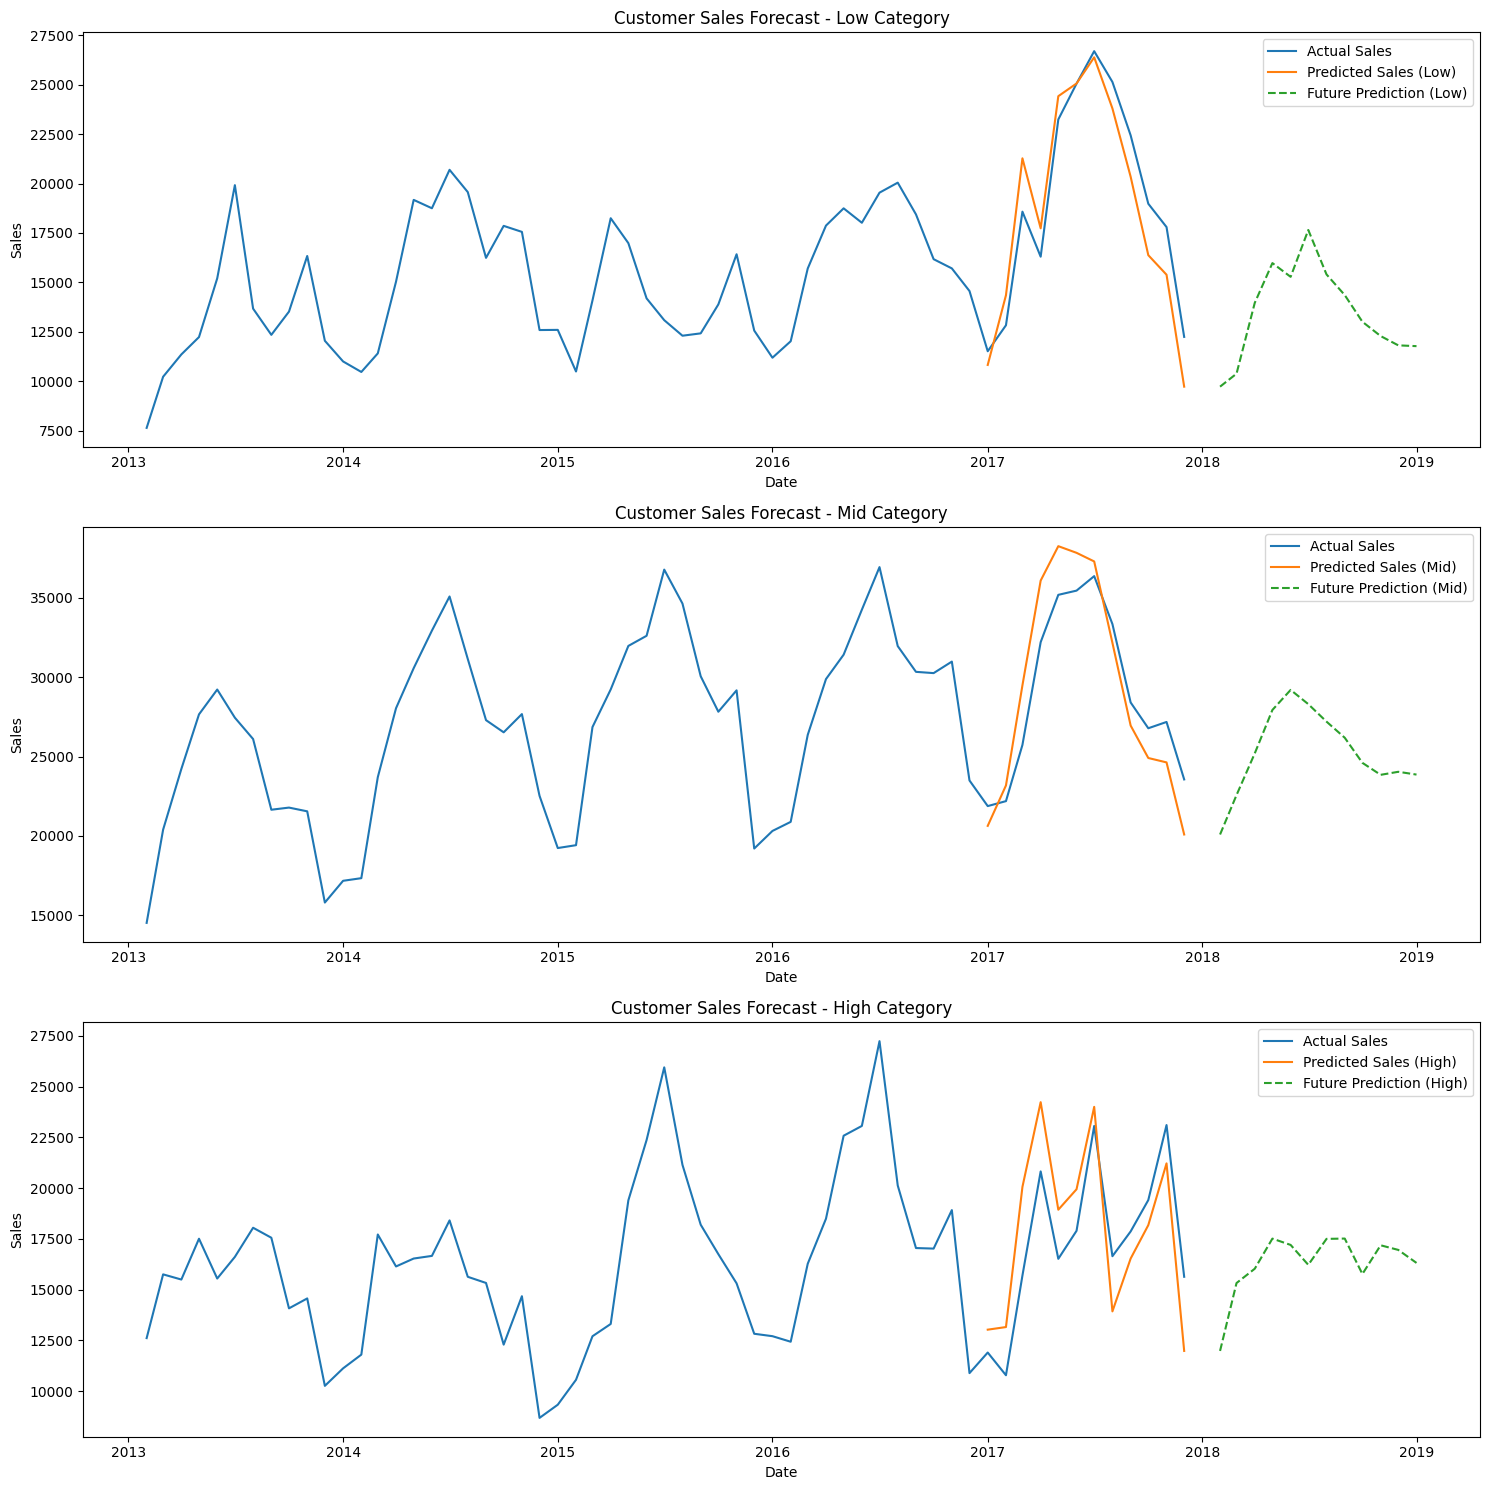

In [26]:
# Plot predictions by category
plt.figure(figsize=(15, 15))

# Low category plot
plt.subplot(3, 1, 1)
plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
plt.plot(low_future_df['date'], low_future_df['LSTM Prediction'], label='Future Prediction (Low)', linestyle='--')
plt.title("Customer Sales Forecast - Low Category")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# Mid category plot
plt.subplot(3, 1, 2)
plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
plt.plot(mid_future_df['date'], mid_future_df['LSTM Prediction'], label='Future Prediction (Mid)', linestyle='--')
plt.title("Customer Sales Forecast - Mid Category")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# High category plot
plt.subplot(3, 1, 3)
plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
plt.plot(high_future_df['date'], high_future_df['LSTM Prediction'], label='Future Prediction (High)', linestyle='--')
plt.title("Customer Sales Forecast - High Category")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load data
url = 'https://raw.githubusercontent.com/C4AnN/Models/GT111/dataset_processing%20(2)/file_gabungan2.csv'
store_sales = pd.read_csv(url)

store_sales['date'] = pd.to_datetime(store_sales['date'])

# Categorize data based on price
def categorize_price(price):
    if price < 8000000:
        return 'low'
    elif 8000000 <= price < 16000000:
        return 'mid'
    else:
        return 'high'

store_sales['category'] = store_sales['price'].apply(categorize_price)

# Drop unnecessary columns
store_sales = store_sales.drop(['name', 'price'], axis=1)

# Function to process and predict for each category
def process_category(data, category_name, window_size):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Prepare supervised data with a window size (6 months)
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, window_size + 1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Split into train and test data
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_{category_name}.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop, model_checkpoint], verbose=1)

    # Save the model
    model.save(f'best_model_{category_name}.keras')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = monthly_sales['sales'][-13:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 12 months
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for month in range(18):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_sales = future_pred[0][0] + monthly_sales['sales'].iloc[-1]
        future_predictions.append(future_sales)

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

        # Update the data for the next iteration to use the predicted value
        if month >= window_size - 1:
            last_data.iloc[0, 1] = next_pred

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return monthly_sales, predict_df, future_df

# Process and predict for each category using window size of 6 months
window_size = 12

low_sales, low_predict_df, low_future_df = process_category(store_sales, 'low', window_size)
mid_sales, mid_predict_df, mid_future_df = process_category(store_sales, 'mid', window_size)
high_sales, high_predict_df, high_future_df = process_category(store_sales, 'high', window_size)

# Plot predictions by category
plt.figure(figsize=(15, 15))

# Low category plot
plt.subplot(3, 1, 1)
plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
plt.plot(low_future_df['date'], low_future_df['LSTM Prediction'], label='Future Prediction (Low)', linestyle='--')
plt.title("Customer Sales Forecast - Low Category (Window Size: 6)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# Mid category plot
plt.subplot(3, 1, 2)
plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
plt.plot(mid_future_df['date'], mid_future_df['LSTM Prediction'], label='Future Prediction (Mid)', linestyle='--')
plt.title("Customer Sales Forecast - Mid Category (Window Size: 6)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# High category plot
plt.subplot(3, 1, 3)
plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
plt.plot(high_future_df['date'], high_future_df['LSTM Prediction'], label='Future Prediction (High)', linestyle='--')
plt.title("Customer Sales Forecast - High Category (Window Size: 6)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - loss: 0.2571 - val_loss: 0.6223
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2228 - val_loss: 0.6215
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2532 - val_loss: 0.5920
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2123 - val_loss: 0.5674
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2288 - val_loss: 0.5425
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2312 - val_loss: 0.5312
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.2057 - val_loss: 0.5301
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2092 - val_loss: 0.4992
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2007 - val_loss: 0.4644
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2148 - val_loss: 0.4507
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.2162 - val_loss: 0.4408
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1998 - val_l

C:\Users\MyPC\AppData\Local\Temp\ipykernel_7032\1403347207.py:125: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


ValueError: All arrays must be of the same length

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - loss: 0.2650 - val_loss: 0.6407
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2463 - val_loss: 0.6395
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.2314 - val_loss: 0.6235
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2397 - val_loss: 0.6036
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.2265 - val_loss: 0.5833
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.2497 - val_loss: 0.5645
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2484 - val_loss: 0.5531
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2220 - val_loss: 0.5435
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.2131 - val_loss: 0.5357
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2163 - val_loss: 0.5331
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1928 - val_loss: 0.5112
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 0.1952

C:\Users\MyPC\AppData\Local\Temp\ipykernel_7832\2456596998.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - loss: 0.2345 - val_loss: 0.1447
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1769 - val_loss: 0.1319
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1863 - val_loss: 0.1269
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2084 - val_loss: 0.1207
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1664 - val_loss: 0.1127
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1383 - val_loss: 0.1042
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1343 - val_loss: 0.0947
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1607 - val_loss: 0.0806
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.1251 - val_loss: 0.0626
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1183 - val_loss: 0.0473
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1064 - val_loss: 0.0557
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1110 - val_loss: 0.0612


C:\Users\MyPC\AppData\Local\Temp\ipykernel_7832\2456596998.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 328ms/step - loss: 0.2469 - val_loss: 0.3596
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2042 - val_loss: 0.3177
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1813 - val_loss: 0.2716
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1787 - val_loss: 0.2834
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1602 - val_loss: 0.3004
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1647 - val_loss: 0.3019
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1298 - val_loss: 0.2939
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.1342 - val_loss: 0.3125
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1415 - val_loss: 0.3172
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1249 - val_loss: 0.3148
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1367 - val_loss: 0.3067
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1419 - val_loss: 0.2879


C:\Users\MyPC\AppData\Local\Temp\ipykernel_7832\2456596998.py:120: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


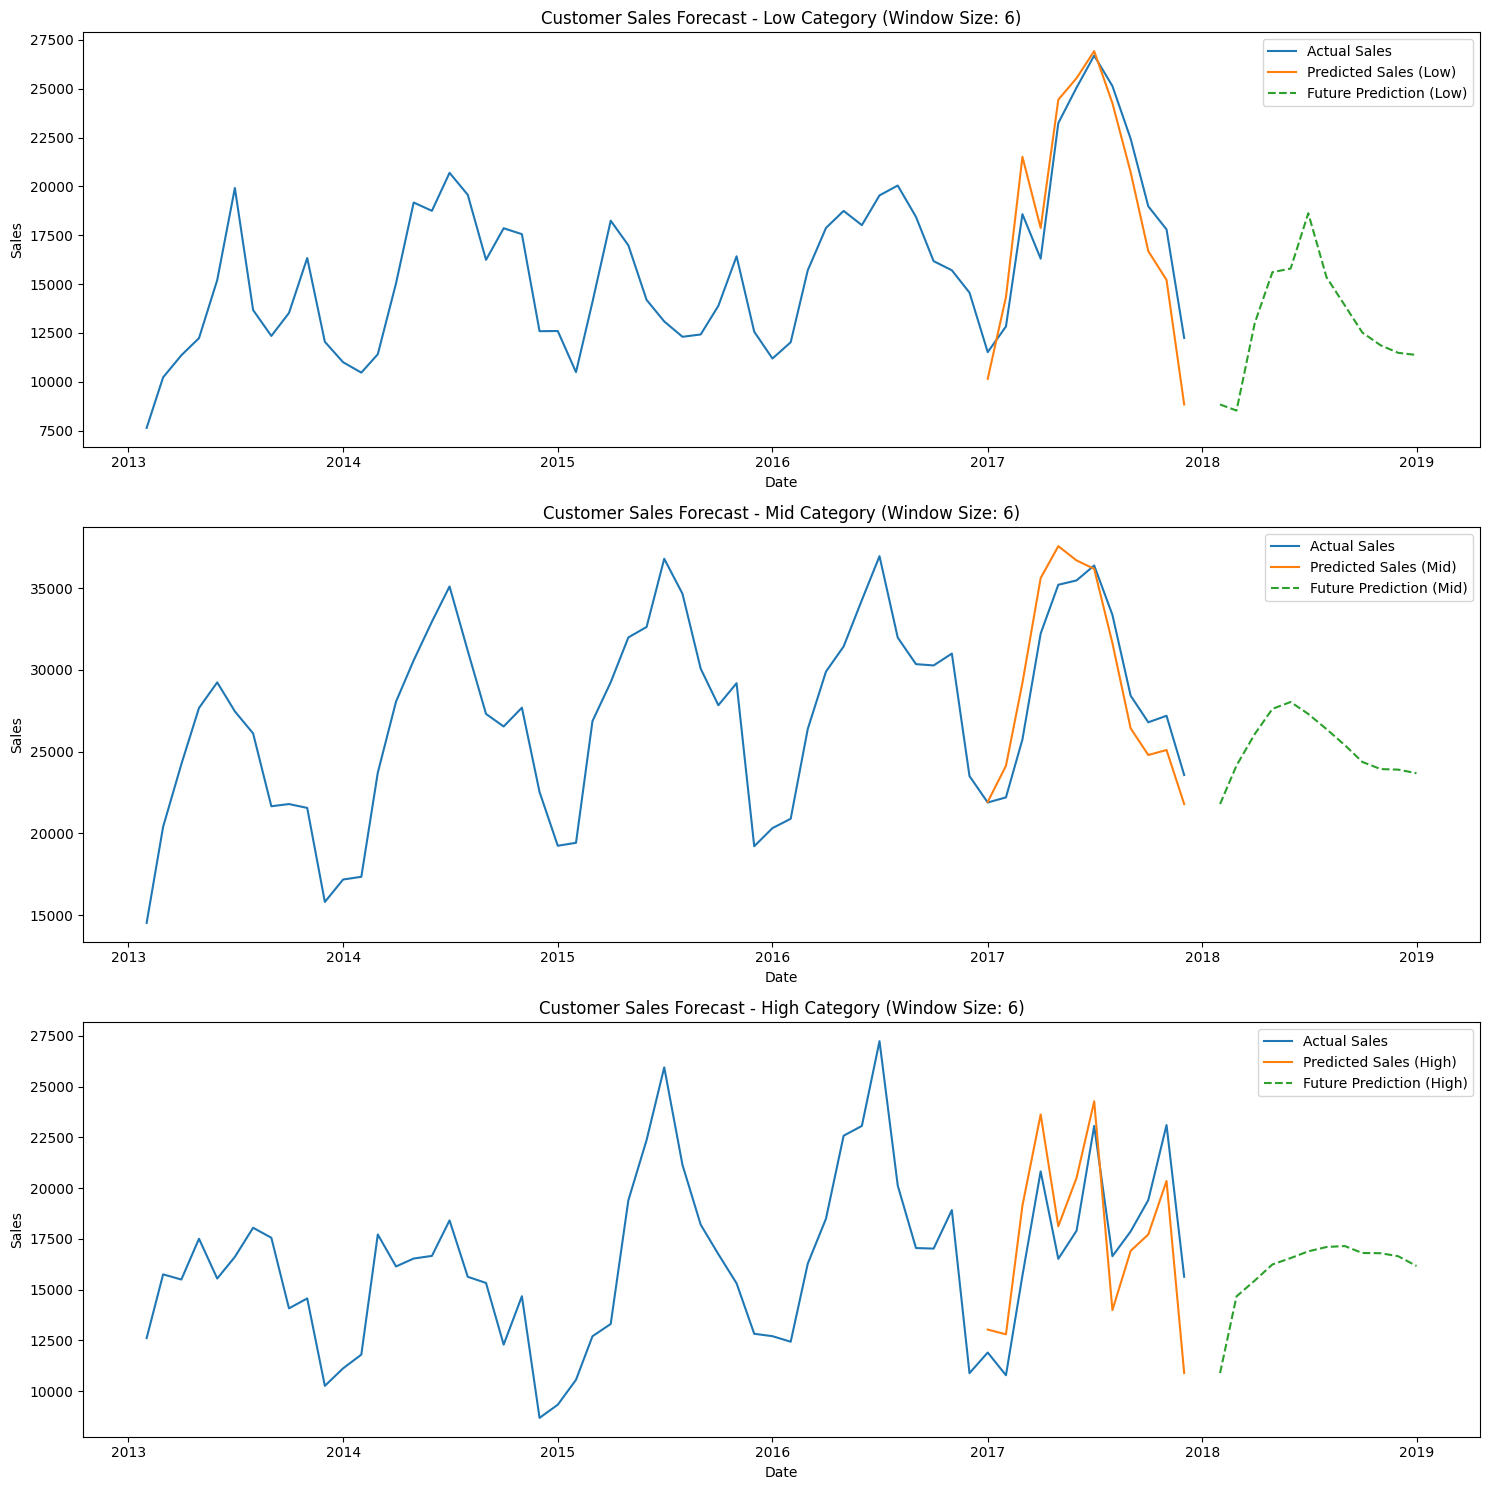

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load data
url = 'https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(Model%20LR%202)/file_gabungan2.csv'
store_sales = pd.read_csv(url)

store_sales['date'] = pd.to_datetime(store_sales['date'])

# Categorize data based on price
def categorize_price(price):
    if price < 8000000:
        return 'low'
    elif 8000000 <= price < 16000000:
        return 'mid'
    else:
        return 'high'

store_sales['category'] = store_sales['price'].apply(categorize_price)

# Drop unnecessary columns
store_sales = store_sales.drop(['name', 'price'], axis=1)

# Function to process and predict for each category
def process_category(data, category_name, window_size):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Prepare supervised data with a window size (6 months)
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, window_size + 1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Split into train and test data
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_{category_name}.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop, model_checkpoint], verbose=1)

    # Save the model
    model.save(f'best_model_{category_name}.keras')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = monthly_sales['sales'][-13:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 12 months
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(12):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + monthly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return monthly_sales, predict_df, future_df

# Process and predict for each category using window size of 6 months
window_size = 12

low_sales, low_predict_df, low_future_df = process_category(store_sales, 'low', window_size)
mid_sales, mid_predict_df, mid_future_df = process_category(store_sales, 'mid', window_size)
high_sales, high_predict_df, high_future_df = process_category(store_sales, 'high', window_size)

# Plot predictions by category
plt.figure(figsize=(15, 15))

# Low category plot
plt.subplot(3, 1, 1)
plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
plt.plot(low_future_df['date'], low_future_df['LSTM Prediction'], label='Future Prediction (Low)', linestyle='--')
plt.title("Customer Sales Forecast - Low Category (Window Size: 6)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# Mid category plot
plt.subplot(3, 1, 2)
plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
plt.plot(mid_future_df['date'], mid_future_df['LSTM Prediction'], label='Future Prediction (Mid)', linestyle='--')
plt.title("Customer Sales Forecast - Mid Category (Window Size: 6)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# High category plot
plt.subplot(3, 1, 3)
plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
plt.plot(high_future_df['date'], high_future_df['LSTM Prediction'], label='Future Prediction (High)', linestyle='--')
plt.title("Customer Sales Forecast - High Category (Window Size: 6)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.tight_layout()
plt.show()


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 382ms/step - loss: 0.2731 - val_loss: 0.8052
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3938 - val_loss: 0.6050
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2104 - val_loss: 0.6236
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3336 - val_loss: 0.6065
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2928 - val_loss: 0.6140
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2615 - val_loss: 0.7487
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.3550 - val_loss: 0.7167
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.3134 - val_loss: 0.6126
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.3050 - val_loss: 0.5801
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2751 - val_loss: 0.5840
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2849 - val_loss: 0.5830
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.3072 - val_l

C:\Users\MyPC\AppData\Local\Temp\ipykernel_7832\2584324605.py:122: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 475ms/step - loss: 0.3316 - val_loss: 0.1839
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.3524 - val_loss: 0.1508
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.3039 - val_loss: 0.0933
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2388 - val_loss: 0.1260
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.2846 - val_loss: 0.0924
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2094 - val_loss: 0.0934
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2667 - val_loss: 0.1078
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2719 - val_loss: 0.0903
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2197 - val_loss: 0.0973
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2495 - val_loss: 0.1153
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.3086 - val_loss: 0.0942
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2651 - val_l

C:\Users\MyPC\AppData\Local\Temp\ipykernel_7832\2584324605.py:122: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 598ms/step - loss: 0.6459 - val_loss: 0.3666
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2487 - val_loss: 0.6372
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4335 - val_loss: 0.5367
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.3355 - val_loss: 0.3680
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1794 - val_loss: 0.3896
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.2296 - val_loss: 0.4369
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2626 - val_loss: 0.3852
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.2221 - val_loss: 0.3571
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.1693 - val_loss: 0.3752
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.1738 - val_loss: 0.3969
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2064 - val_loss: 0.4044
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.2019 - val

C:\Users\MyPC\AppData\Local\Temp\ipykernel_7832\2584324605.py:122: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')


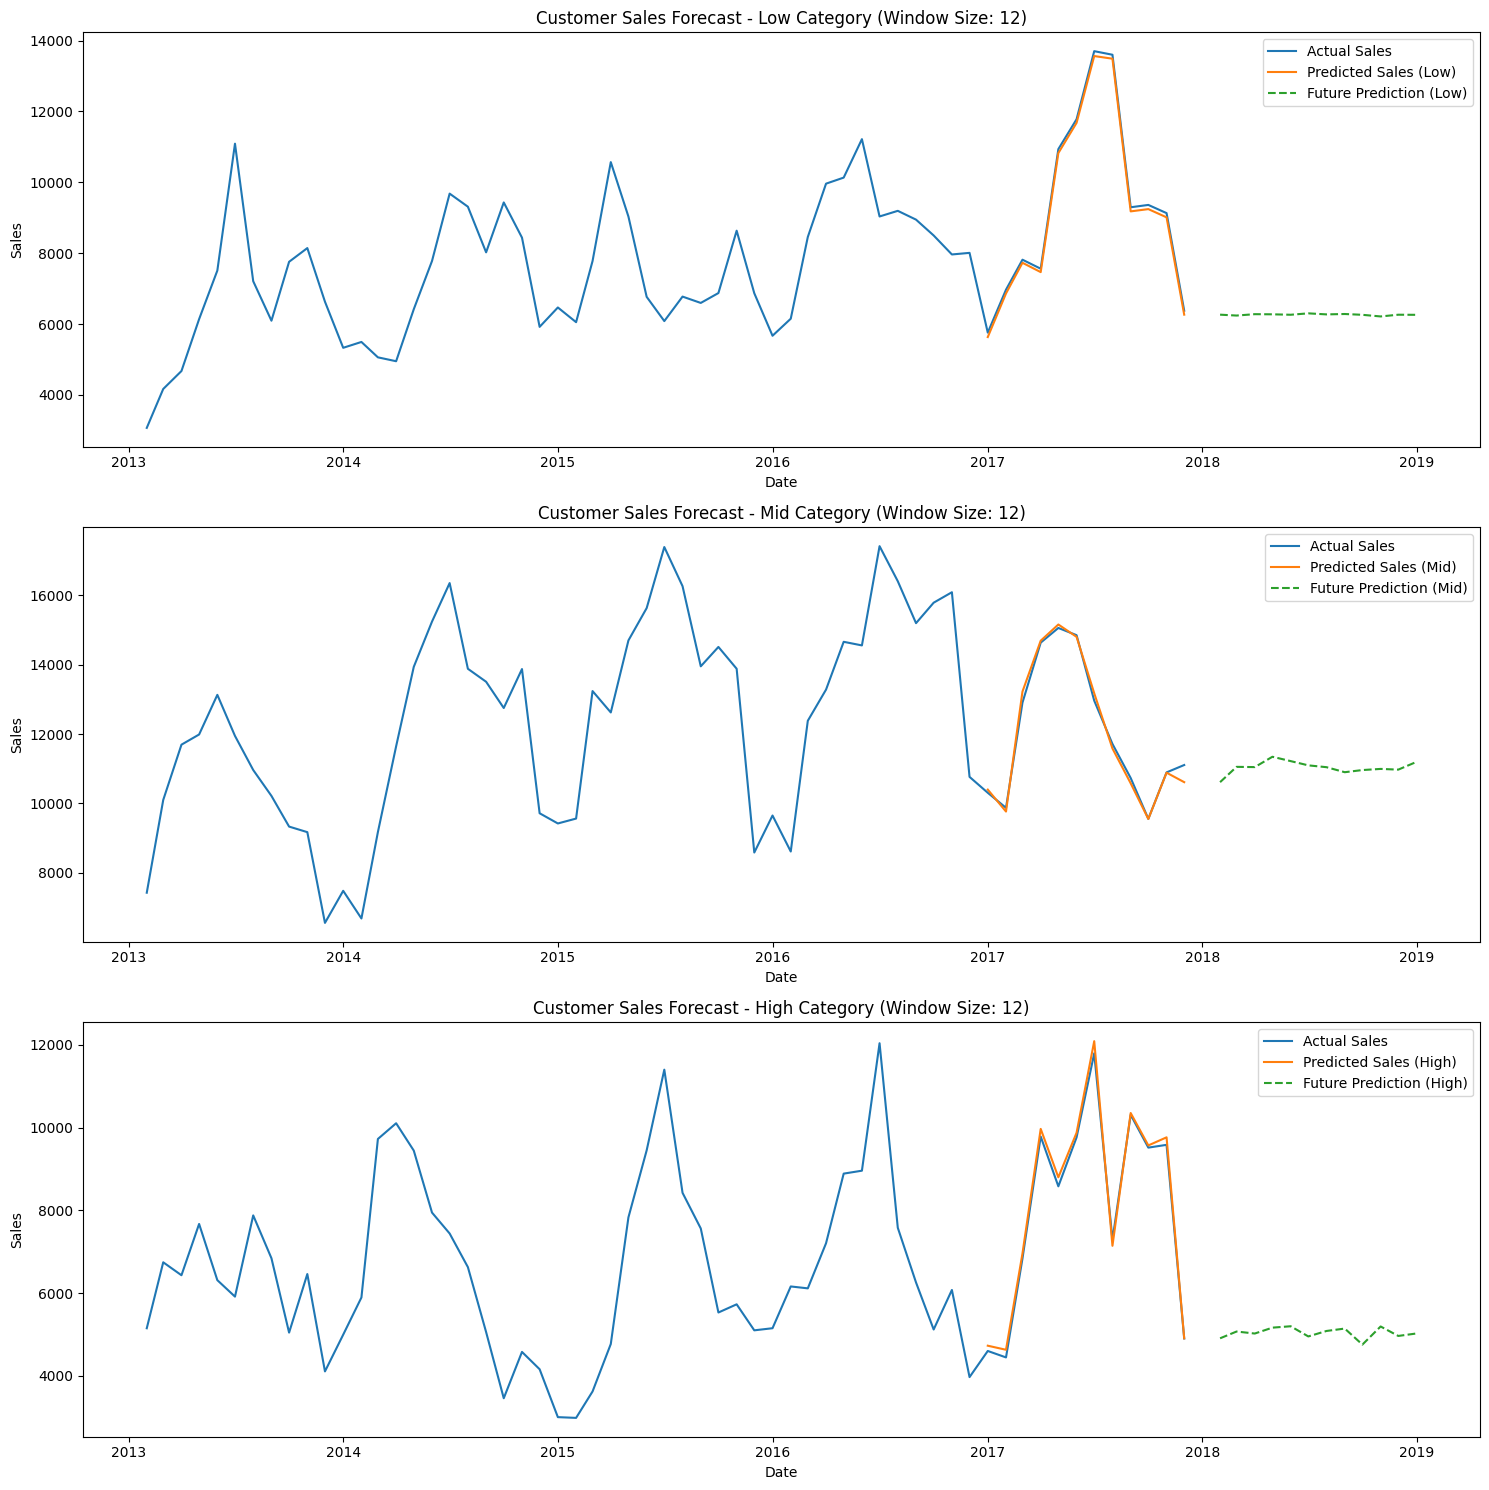

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Load data
url = 'https://raw.githubusercontent.com/C4AnN/Models/data/dataset/test_subset40000.csv'
store_sales = pd.read_csv(url)

store_sales['date'] = pd.to_datetime(store_sales['date'])

# Categorize data based on price
def categorize_price(price):
    if price < 8000000:
        return 'low'
    elif 8000000 <= price < 16000000:
        return 'mid'
    else:
        return 'high'

store_sales['category'] = store_sales['price'].apply(categorize_price)

# Drop unnecessary columns
store_sales = store_sales.drop(['name', 'price'], axis=1)

# Function to process and predict for each category
def process_category(data, category_name, window_size):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("M")
    monthly_sales = data.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

    # Calculate sales difference
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    # Prepare supervised data with a window size
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, window_size + 1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)

    # Split into train and test data
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(100, activation='sigmoid', return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(100, activation='sigmoid'))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'best_model_{category_name}.keras', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop, model_checkpoint], verbose=1)

    # Save the model
    model.save(f'best_model_{category_name}.keras')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = monthly_sales['sales'][-13:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 12 months
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(12):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + monthly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=monthly_sales['date'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return monthly_sales, predict_df, future_df

# Process and predict for each category using window size of 6 months
window_size = 12  # Increase window size to consider more historical data

low_sales, low_predict_df, low_future_df = process_category(store_sales, 'low', window_size)
mid_sales, mid_predict_df, mid_future_df = process_category(store_sales, 'mid', window_size)
high_sales, high_predict_df, high_future_df = process_category(store_sales, 'high', window_size)

# Plot predictions by category
plt.figure(figsize=(15, 15))

# Low category plot
plt.subplot(3, 1, 1)
plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
plt.plot(low_future_df['date'], low_future_df['LSTM Prediction'], label='Future Prediction (Low)', linestyle='--')
plt.title("Customer Sales Forecast - Low Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# Mid category plot
plt.subplot(3, 1, 2)
plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
plt.plot(mid_future_df['date'], mid_future_df['LSTM Prediction'], label='Future Prediction (Mid)', linestyle='--')
plt.title("Customer Sales Forecast - Mid Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

# High category plot
plt.subplot(3, 1, 3)
plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
plt.plot(high_future_df['date'], high_future_df['LSTM Prediction'], label='Future Prediction (High)', linestyle='--')
plt.title("Customer Sales Forecast - High Category (Window Size: 12)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()

plt.tight_layout()
plt.show()
